In [231]:
import matplotlib.pyplot as plt
import numpy as np
import random
import scipy.stats as stats
import seaborn as sns

## Classes & Functions

#### Algorithms

In [259]:
class SimulatedAnnealing:
    def __init__(self, starting_route, temperature, rate, nodes, markov_length, temperature_minimum=1e-5):
        self.initial_solution = starting_route
        self.current_solution = self.initial_solution
        self.temperature = temperature
        self.nodes = nodes
        self.markov_length = markov_length
        self.temperature_minimum = temperature_minimum
        self.n = len(self.initial_solution)
        self.rate = rate
        self.steps = 0
        self.plot_steps = list()
        self.scores = list()

        self.current_score = self.distance(self.initial_solution)

    def distance(self, current_state) -> int:
        return sum([self.nodes[current_state[i]].distance(self.nodes[current_state[i + 1]]) for i in range(len(current_state) - 1)])

    def update_temperature(self) -> None:
        self.temperature = self.temperature * self.rate

    def two_opt_move(self, solution) -> list:
        i, j = np.sort(np.random.randint(1, self.n - 1, 2))
        while abs(i - j) <=1:
            i, j = np.sort(np.random.randint(1, self.n - 1, 2))
        new_solution = solution[:i] + solution[i:j][::-1] + solution[j:]
        return new_solution

    def run(self) -> list:
        while self.temperature > self.temperature_minimum:
            for _ in range(self.markov_length):
                cur_sol = self.current_solution
                new_solution = self.two_opt_move(cur_sol)
                new_score = self.distance(new_solution)

                if self.current_score > new_score:
                    self.current_score = new_score
                    self.current_solution = new_solution
                else:
                    score_diff = self.current_score - new_score
                    if np.exp(score_diff/self.temperature) > random.random():
                        self.current_solution = new_solution
                        self.current_score = new_score

            self.steps += 1
            if self.steps % 100 ==0:
                self.plot_steps.append(self.steps)
                self.scores.append(self.current_score)

            self.update_temperature()

        return self.current_solution, self.current_score

In [289]:
def create_random(starting_list) -> list:
    """
    Creates random initial solution, it shuffles the list and returns it.
    """
    random.shuffle(starting_list)
    starting_list.append(1)
    starting_list = [1] + starting_list
    return starting_list

#### Network

In [31]:
class Node:
    def __init__(self, coordinates, number):
        self.number = number
        self.x, self.y = coordinates

    def distance(self, b) -> int:
        return np.linalg.norm(np.array(self.get_coordinates())
            - np.array(b.get_coordinates()))

    def get_coordinates(self) -> list:
        return [self.x, self.y]

#### Helper

In [292]:
def load_data(file_name) -> dict:
    """
    Loads in a text file with the given file name and creates a node for every
    point. Returns a list of nodes.
    """
    file = open(f'TSP-Configurations/{file_name}.tsp.txt', "r")
    file = file.read().splitlines()[6:-1]
    nodes = dict()
    ids = list()

    # Go through every line of the file and create node for every line.
    for node in file:
        values = [int(value) for value in node.split()]
        nodes[values[0]] = Node([values[1], values[2]], values[0])
        if values[0] == 1:
            continue
        else:
            ids.append(values[0])

    # Return the list of nodes.
    return nodes, ids


In [56]:
def calculate_optimal(nodes, file_name) -> float:
    """
    Takes the dictionary of nodes and calculates the distance travelled of the
    optimal tour. This serves as a benchmark for the Simulated Annealing
    algorithm.
    """

    optimal = open(f'TSP-Configurations/{file_name}.opt.tour.txt', "r")
    optimal = optimal.read().splitlines()[5:-1]
    return sum([nodes[int(optimal[i])].distance(nodes[abs(int(optimal[i + 1]))]) for i in range(len(optimal) - 1)])

In [88]:
def calculate_current_score(nodes, current_state) -> float:
    return sum([nodes[current_state[i]].distance(nodes[current_state[i + 1]]) for i in range(len(current_state) - 1)])


#### Plotting

In [238]:
def convergence_plotter(scores_list, steps, optimal_score) -> None:
    scores_list = np.array(scores_list)
    means = np.mean(scores_list, axis=0)
    print(means[-1])
    sem = stats.sem(scores_list, axis=0)
    ci_lower = means - 1.96 * sem
    ci_upper = means + 1.96 * sem
    plt.plot(steps, means, label='Mean', color='blue')
    plt.fill_between(steps, ci_lower, ci_upper, color='lightblue', alpha=0.3, label='95% CI')
    plt.axhline(y=optimal_score, color='g', linestyle='-')
    plt.title('Convergence')
    plt.ylabel('Distance')
    plt.xlabel('Steps')
    plt.legend()
    plt.show()

## Testing

Testing happens on the configuration of the eli51.tsp file. For experiments the bigger
network a280.tsp is used. 

In [305]:
# Create simple TSP
file_name = 'eil51'
nodes, initial_list = load_data(file_name)
copy_initial = initial_list.copy()
temperature = 10000
rate = 0.99
markov_length = 150

In [306]:
random_start = create_random(copy_initial)
siman = SimulatedAnnealing(random_start, temperature, rate, nodes, markov_length)

In [307]:
solution, score = siman.run()

In [308]:
score

463.1702064971314

In [309]:
print(solution)

[1, 22, 2, 29, 21, 50, 34, 30, 39, 10, 49, 9, 16, 38, 5, 12, 47, 18, 4, 17, 37, 15, 33, 45, 44, 42, 19, 40, 41, 13, 25, 14, 6, 51, 46, 11, 32, 27, 48, 23, 24, 43, 7, 26, 8, 31, 28, 3, 20, 36, 35, 1]


In [253]:
calculate_optimal(nodes, file_name)

2548.8811037431624

In [235]:
scores_list = list()
for i in range(20):
    random_start = create_random(copy_initial)
    siman = SimulatedAnnealing(random_start, temperature, rate, nodes, markov_length)
    siman.run()
    scores_list.append(siman.scores)

473.4220941414811


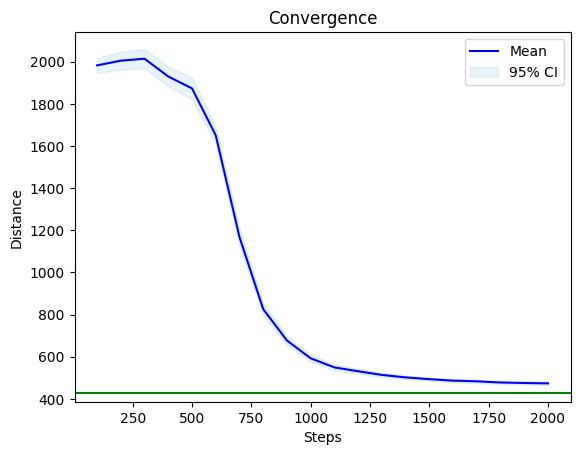

In [239]:
convergence_plotter(scores_list, siman.plot_steps, calculate_optimal(nodes, file_name))

## Experiments

#### Cooldown schedule

#### Markov chain length